In [590]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import geopandas

import random

import warnings
warnings.filterwarnings('ignore')

In [591]:
data_global_temp = pd.read_csv(
    'data/GlobalTemperatures.csv',
    parse_dates=True,
    index_col='dt'
)
data_global_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 8 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   LandAverageTemperature                     3180 non-null   float64
 1   LandAverageTemperatureUncertainty          3180 non-null   float64
 2   LandMaxTemperature                         1992 non-null   float64
 3   LandMaxTemperatureUncertainty              1992 non-null   float64
 4   LandMinTemperature                         1992 non-null   float64
 5   LandMinTemperatureUncertainty              1992 non-null   float64
 6   LandAndOceanAverageTemperature             1992 non-null   float64
 7   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8)
memory usage: 224.4 KB


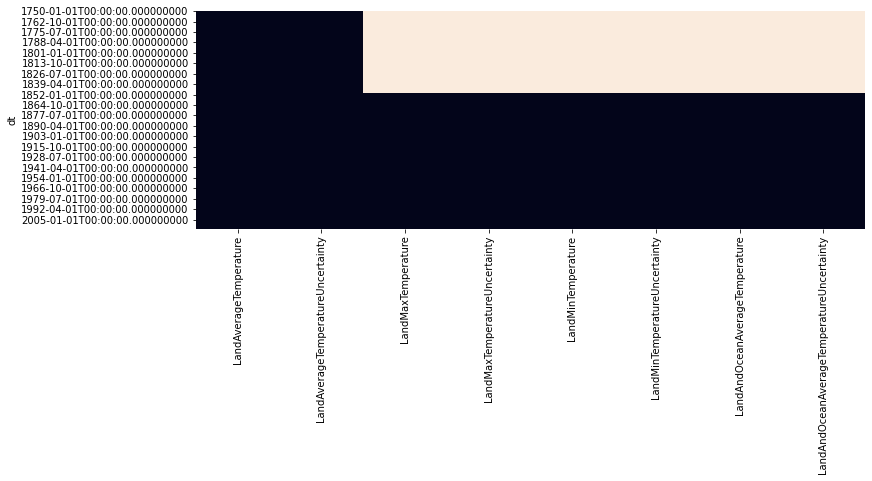

In [592]:
plt.figure(figsize=(12, 4))

sns.heatmap(data_global_temp.isnull(), cbar=False)

plt.show()

In [593]:
data_global_temp.dropna(axis=0, inplace=True)

data_global_temp['year'] = data_global_temp.index.year
data_global_temp['week'] = data_global_temp.index.week
data_global_temp['month'] = data_global_temp.index.month

In [594]:
print("Distribution of Week")
print(data_global_temp.week.value_counts())
print("Distribution of year")
print(data_global_temp.year.value_counts())
print("Distribution of month")
print(data_global_temp.month.value_counts())

Distribution of Week
5     166
9     160
44    160
31    149
22    136
18    125
48    112
35    112
40    102
1      96
26     88
13     88
27     78
14     78
39     64
36     54
49     54
17     41
52     41
23     30
53     29
30     17
45      6
10      6
Name: week, dtype: int64
Distribution of year
1850    12
1954    12
1956    12
1957    12
1958    12
        ..
1906    12
1907    12
1908    12
1909    12
2015    12
Name: year, Length: 166, dtype: int64
Distribution of month
1     166
2     166
3     166
4     166
5     166
6     166
7     166
8     166
9     166
10    166
11    166
12    166
Name: month, dtype: int64


In [595]:
# Week is not evenly distributed, let us deal with year or month.

In [596]:
earth_data = data_global_temp.groupby(by='year')[[
    'LandAverageTemperature',
    'LandAverageTemperatureUncertainty',
    'LandMaxTemperature',
    'LandMaxTemperatureUncertainty',
    'LandMinTemperature',
    'LandMinTemperatureUncertainty',
    'LandAndOceanAverageTemperature',
    'LandAndOceanAverageTemperatureUncertainty'
]].mean().reset_index()

earth_data.describe()

,year,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,1932.500000,8.571583,0.276663,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,48.064193,0.473687,0.208560,0.447741,0.549759,0.614124,0.406697,0.298629,0.071441
min,1850.000000,7.558583,0.062083,13.081000,0.078500,1.525083,0.102500,14.740083,0.047500
25%,1891.250000,8.195708,0.094333,14.055917,0.139542,2.262562,0.149896,14.991208,0.062937
50%,1932.500000,8.540750,0.240625,14.307708,0.240125,2.734917,0.274667,15.144208,0.123625
75%,1973.750000,8.791250,0.341958,14.539167,0.508000,3.126833,0.437000,15.379104,0.150229
max,2015.000000,9.831000,0.918250,15.572667,2.619250,4.148833,1.778500,16.058583,0.316417


- LandAverageTemperature: We can see that, the median and the min, max values does not differ by a considerable amount, due to which the deviation is also a bit less (means, I am saying on the basis of the normal deviation values, maybe this small scale also holds a high importance, in practical scenarios)

- LandMaxTemperature: Similar is the case of LandMaxTemperature

- LandMinTemperature: This is an important column, and we can see that, the deviation is the highest among all the other columns, hence we can say that with the years, the min temperature has also increased, min is around 1.5, and has a max value of 4.14

- LandAndOceanAverageTemperature: This column, has the lowest deviation, and hence, we can say that with advent in years, basically there has not been a significant increase in this quantity

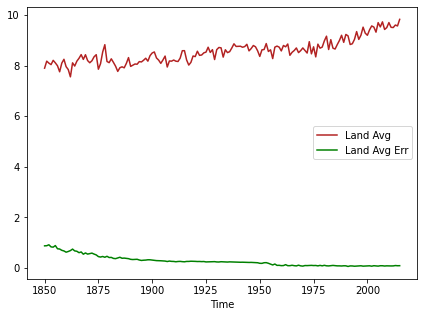

In [597]:
land_avg = data_global_temp.groupby('year')[
    'LandAverageTemperature',
    'LandAverageTemperatureUncertainty'
].mean().reset_index()

plt.figure(figsize=(7, 5))

plt.plot(
    land_avg['year'],
    land_avg['LandAverageTemperature'],
    label='Land Avg',
    color='firebrick'
)
plt.plot(
    land_avg['year'],
    land_avg['LandAverageTemperatureUncertainty'],
    label='Land Avg Err',
    color='green'
)

plt.xlabel('Time')
plt.legend()
plt.show()

We can see that, with the increase in the years, the average land temperature is increasing and the spread of the data is becoming saturated. The meaning of saturation is, that in a given year, the variablity in the temperature across all the months is decreasing, which is a sign of carefulness for us.

What could be the reason for the increase in the temperature:
Increase proportion of Carbon Dioxide.
What are the reasons for increase in Carbon Dioxide, the industries are primary reasons, then from here, we can link it to industrial revolution, machine automations, etc. And also, the Ozone layer depleted, which can be accounted to the CFC



In [598]:
# https://www.kaggle.com/andradaolteanu/country-mapping-iso-continent-region?select=continents2.csv

continents = pd.read_csv(
    'data/continents2.csv'
)

continents = continents.rename(
    {'name': 'Country'},
    axis='columns'
)

continents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   249 non-null    object 
 1   alpha-2                   248 non-null    object 
 2   alpha-3                   249 non-null    object 
 3   country-code              249 non-null    int64  
 4   iso_3166-2                249 non-null    object 
 5   region                    248 non-null    object 
 6   sub-region                248 non-null    object 
 7   intermediate-region       107 non-null    object 
 8   region-code               248 non-null    float64
 9   sub-region-code           248 non-null    float64
 10  intermediate-region-code  107 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 21.5+ KB


In [599]:
data_by_city = pd.read_csv(
    'data/GlobalLandTemperaturesByCity.csv',
    parse_dates=True,
    index_col='dt'
)
data_by_city.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8599212 entries, 1743-11-01 to 2013-09-01
Data columns (total 6 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   AverageTemperature             float64
 1   AverageTemperatureUncertainty  float64
 2   City                           object 
 3   Country                        object 
 4   Latitude                       object 
 5   Longitude                      object 
dtypes: float64(2), object(4)
memory usage: 459.2+ MB


In [600]:
data_by_country = pd.read_csv(
    'data/GlobalLandTemperaturesByCountry.csv',
    parse_dates=True,
    index_col='dt'
)
data_by_country.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 577462 entries, 1743-11-01 to 2013-09-01
Data columns (total 3 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   AverageTemperature             544811 non-null  float64
 1   AverageTemperatureUncertainty  545550 non-null  float64
 2   Country                        577462 non-null  object 
dtypes: float64(2), object(1)
memory usage: 17.6+ MB


In [601]:
location = pd.read_csv('data/countries_latitude_longitude.csv')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

def get_world_map(year):
    sample = data_by_country.loc[data_by_country.index.year == year]
    sample = sample.groupby('Country').mean().reset_index()
    
    sample = sample.rename({'Country': 'name'}, axis='columns')
    sample = sample.merge(location, on='name')
    
    wm = pd.merge(world, sample, on='name')
    
    return wm

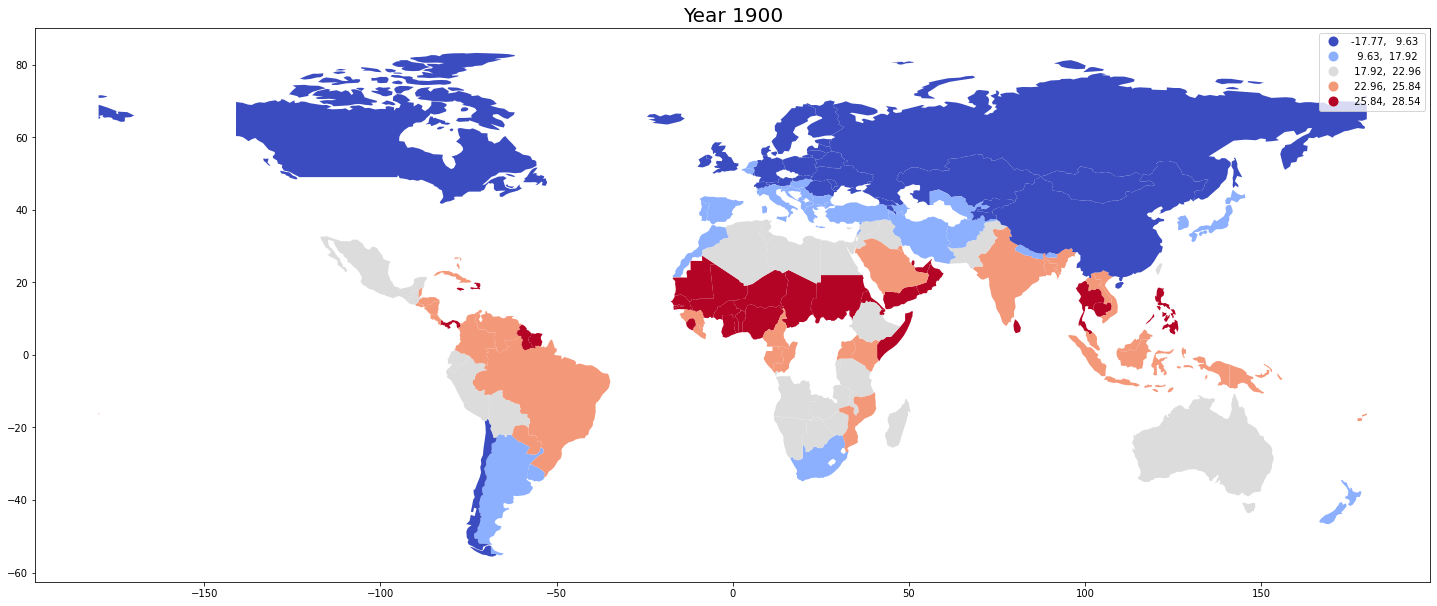

In [602]:
world_map_1900 = get_world_map(1900)

world_map_1900.plot(
    column='AverageTemperature',
    scheme='quantiles',
    figsize=(25, 20),
    legend=True,
    cmap='coolwarm'
)

plt.title("Year 1900", fontsize=20)
plt.show()

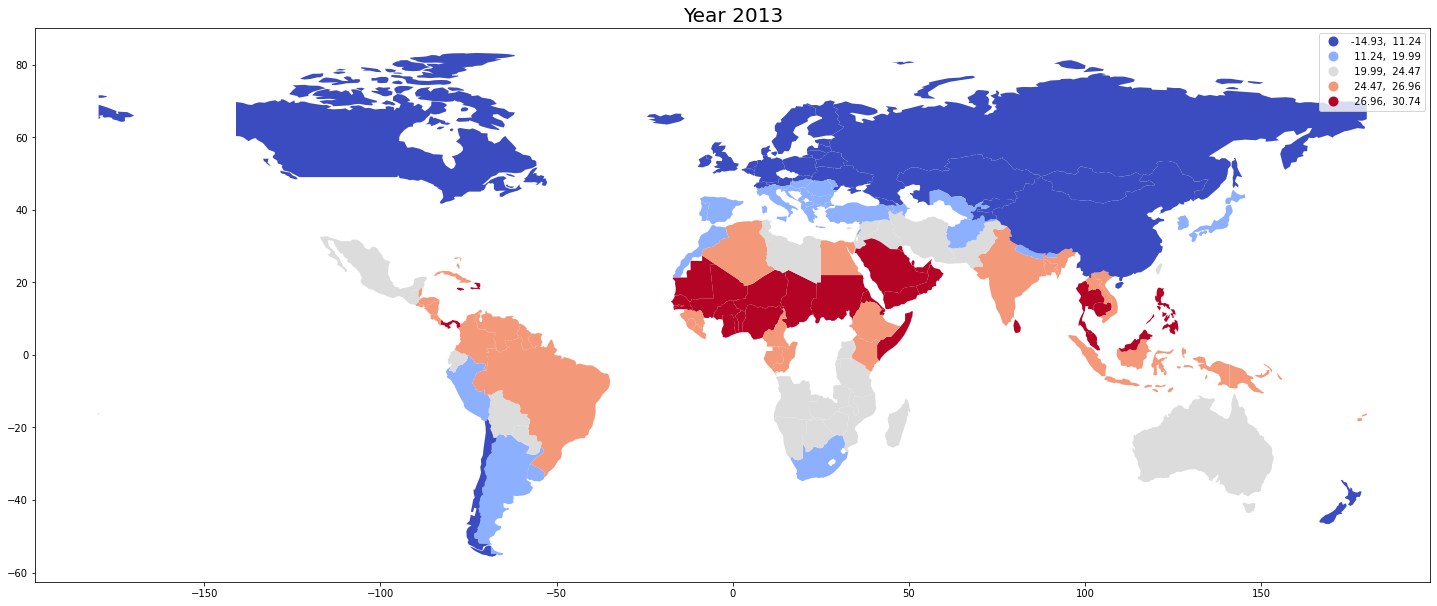

In [603]:
world_map_2013 = get_world_map(2013)

world_map_2013.plot(
    column='AverageTemperature',
    scheme='quantiles',
    figsize=(25, 20),
    legend=True,
    cmap='coolwarm'
)
plt.title("Year 2013", fontsize=20)
plt.show()

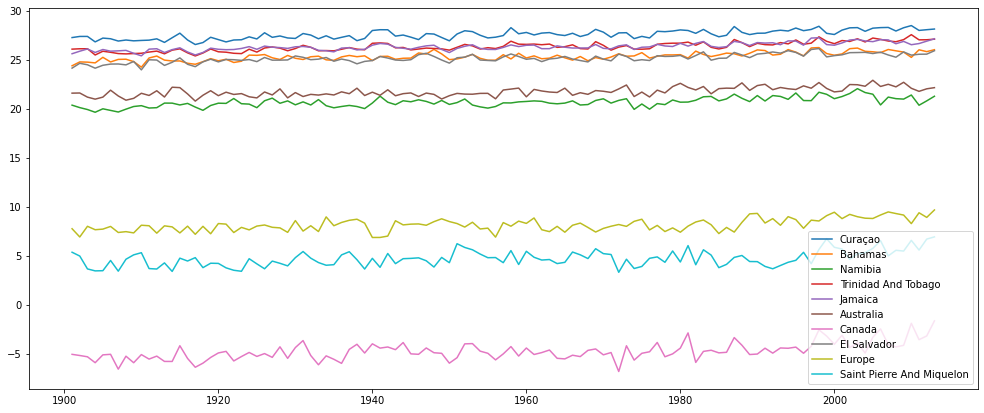

In [604]:
countries = pd.unique(data_by_country['Country'])

plt.figure(figsize=(17, 7))

for country in random.sample(list(countries), 10):
    sample = data_by_country.loc[
        (data_by_country['Country'] == country) &
        (data_by_country.index.year > 1900)
    ]
    sample['y'] = pd.Series(sample.index.year, index=sample.index)
    datum = sample.groupby('y').AverageTemperature.mean().reset_index()
    
    plt.plot(
        datum.y,
        datum.AverageTemperature,
        label=country
    )

plt.legend()
plt.show()

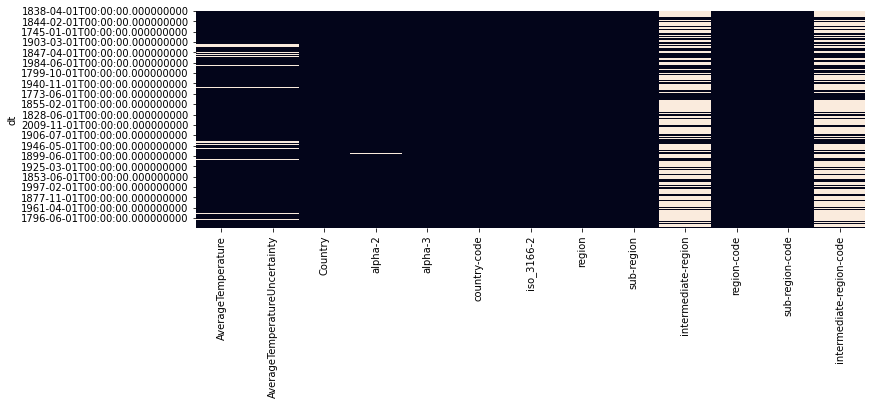

In [605]:
data_by_country['dt'] = data_by_country.index
region = pd.merge(data_by_country, continents, on='Country')
region = region.set_index('dt')

plt.figure(figsize=(12, 4))

sns.heatmap(region.isnull(), cbar=False)

plt.show()

In [606]:
# cleanup
del region['intermediate-region']
del region['intermediate-region-code']
del region['alpha-2']
del region['alpha-3']

region.fillna(method='bfill')
region.dropna()
region.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code
dt,,,,,,,,,
1838-04-01,13.008,2.586,Afghanistan,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1838-05-01,NaN,NaN,Afghanistan,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1838-06-01,23.950,2.510,Afghanistan,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1838-07-01,26.877,2.883,Afghanistan,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1838-08-01,24.938,2.992,Afghanistan,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0


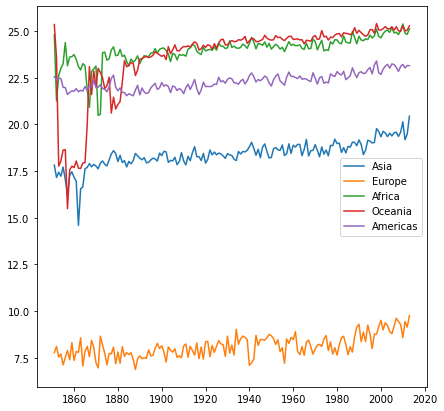

In [607]:
plt.figure(figsize=(7, 7))

cs = pd.unique(region['region'].dropna())
for c in cs:
    sample = region.loc[(region['region'] == c) & (region.index.year > 1850)]
    plt.plot(
        sample.groupby(sample.index.year)['AverageTemperature'].mean(),
        label=c
    )

plt.legend()
plt.show()

Lets analyze more, by pinpointing to a specific city, what better city than Boston which has all the four seasons (spring, summer, fall, winter) 

In [608]:
boston = data[data['City'] == 'Boston']
boston.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,1.188,1.531,Boston,United States,42.59N,72.00W
1743-12-01,NaN,NaN,Boston,United States,42.59N,72.00W
1744-01-01,NaN,NaN,Boston,United States,42.59N,72.00W
1744-02-01,NaN,NaN,Boston,United States,42.59N,72.00W
1744-03-01,NaN,NaN,Boston,United States,42.59N,72.00W


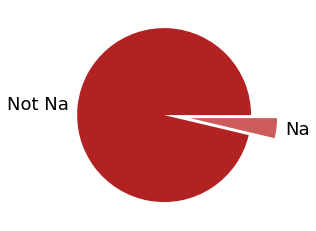

In [609]:
plt.pie(
    boston['AverageTemperature'].isna().value_counts(),
    explode=(0, 0.3),
    startangle=0,
    colors=['firebrick', 'indianred'],
    labels=['Not Na', 'Na'],
    textprops={
        'fontsize': 18
    }
)
plt.show()

In [610]:
boston.AverageTemperature = boston.AverageTemperature.fillna(method='bfill')

In [611]:
boston.AverageTemperatureUncertainty = boston.AverageTemperatureUncertainty.fillna(method='bfill')

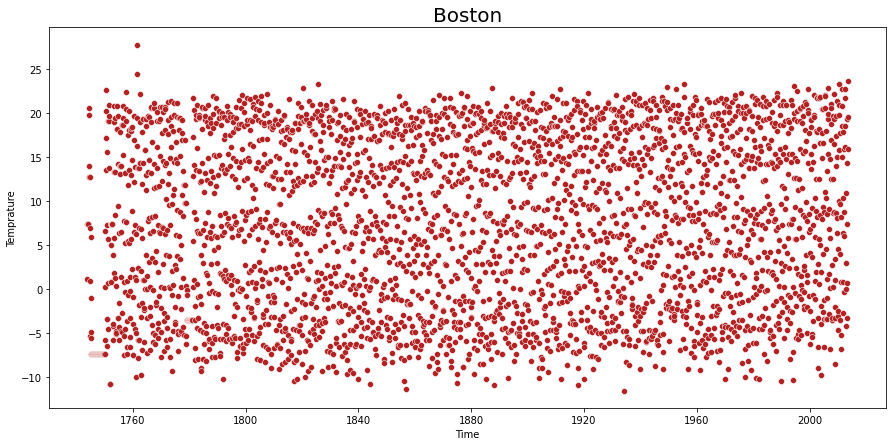

In [612]:
plt.figure(figsize=(15 ,7))
sns.scatterplot(
    x=boston.index,
    y=boston.AverageTemperature,
    color='firebrick',
)
plt.title('Boston', fontsize=20)
plt.xlabel('Time')
plt.ylabel('Temprature')
plt.show()

In [613]:
boston_60_70 = boston.loc[(boston.index.year >= 1960) & (boston.index.year <= 1970)]

In [614]:
def autocorr(df):
    autocorrelation = list()
    for shift in range(1, df.shape[0]):
        correlation = np.corrcoef(
            df.AverageTemperature[:-shift],
            df.AverageTemperature[shift:])[0, 1]
        autocorrelation.append(correlation)
    return autocorrelation

In [615]:
autocorrelation = autocorr(boston_60_70)

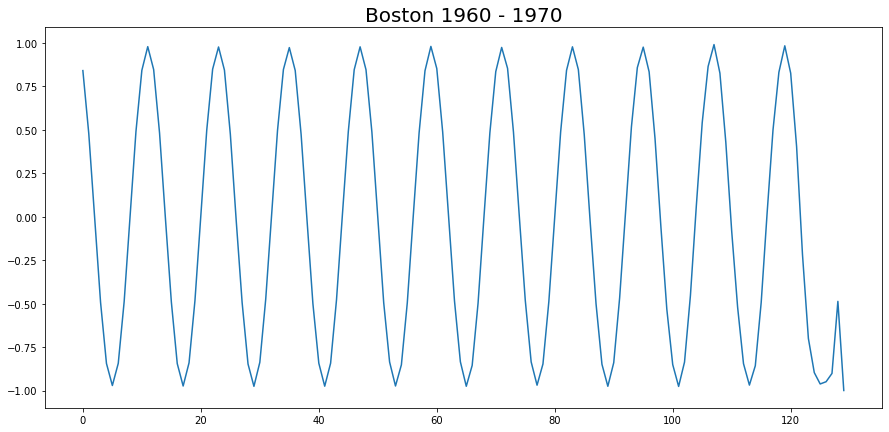

In [616]:
plt.figure(figsize=(15, 7))
plt.title("Boston 1960 - 1970", fontsize=20)
plt.plot(autocorrelation)
plt.show()

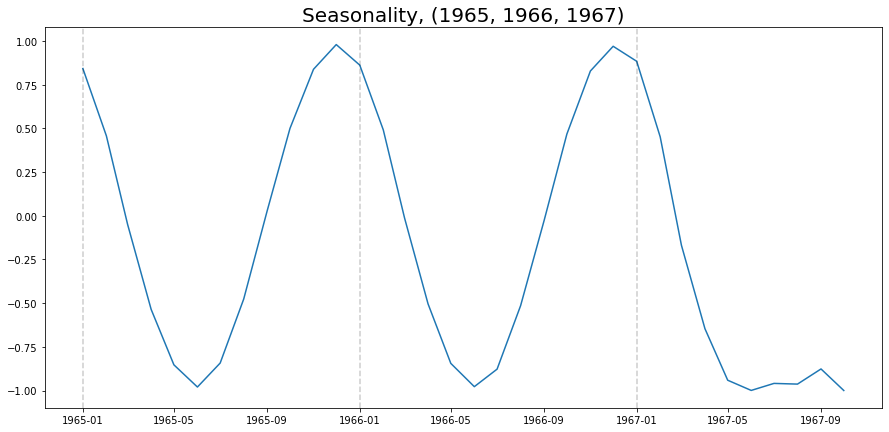

In [617]:
tmp = boston_60_65.loc[boston_60_70.index.year.isin([1965,1966,1967])]
x = tmp.index[:-1]
tmp_ac = autocorr(tmp)

plt.figure(figsize=(15, 7))
plt.title('Seasonality, (1965, 1966, 1967)', fontsize=20)
plt.plot(x, tmp_ac)

for year in [1965,1966,1967]:
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

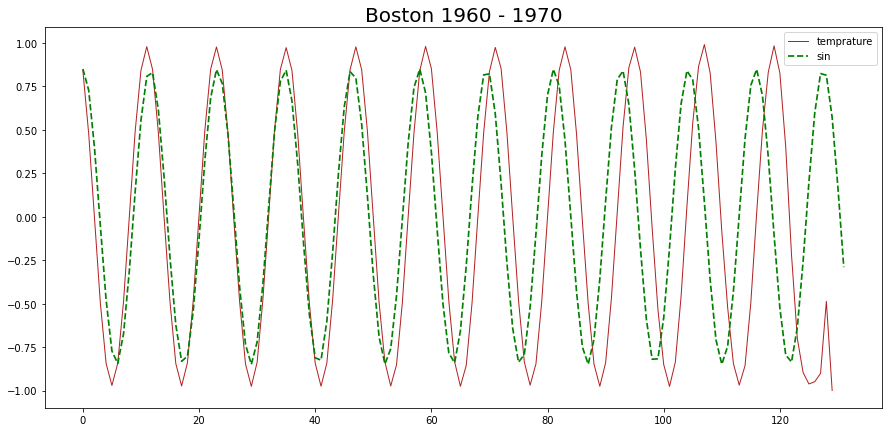

In [618]:
plt.figure(figsize=(15 ,7))

d = np.arange(boston_60_70.shape[0])
# starts at the peak
f = .85 * np.cos(63 * np.pi * d / 365)

plt.plot(autocorrelation, color='firebrick', linewidth=1, label='temprature')
plt.plot(f, '--', color='green', linewidth=1.7, label='sin')
plt.legend()
plt.title('Boston 1960 - 1970', fontsize=20)
plt.show()

The seasonality does not hold for long periods on the timeseries

In [619]:
# boston monthly
bostonM = boston.asfreq('M', method='bfill')
bostonM.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-30,7.394,2.19,Boston,United States,42.59N,72.00W
1743-12-31,7.394,2.19,Boston,United States,42.59N,72.00W
1744-01-31,7.394,2.19,Boston,United States,42.59N,72.00W
1744-02-29,7.394,2.19,Boston,United States,42.59N,72.00W
1744-03-31,7.394,2.19,Boston,United States,42.59N,72.00W


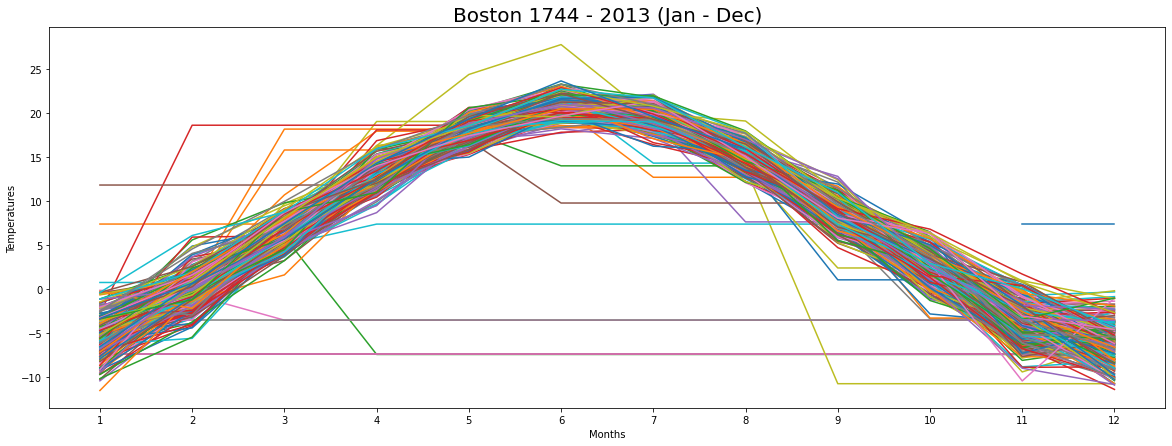

In [620]:
bostonM['year'] = bostonM.index.year
bostonM['month'] = bostonM.index.month

pivot = pd.pivot_table(
    bostonM,
    values='AverageTemperature',
    index='month',
    columns='year',
    aggfunc='mean'
)
pivot.plot(figsize=(20, 7))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([i for i in range(1,13)])
plt.legend().remove()
plt.title('Boston 1744 - 2013 (Jan - Dec)', fontsize=20)
plt.show()

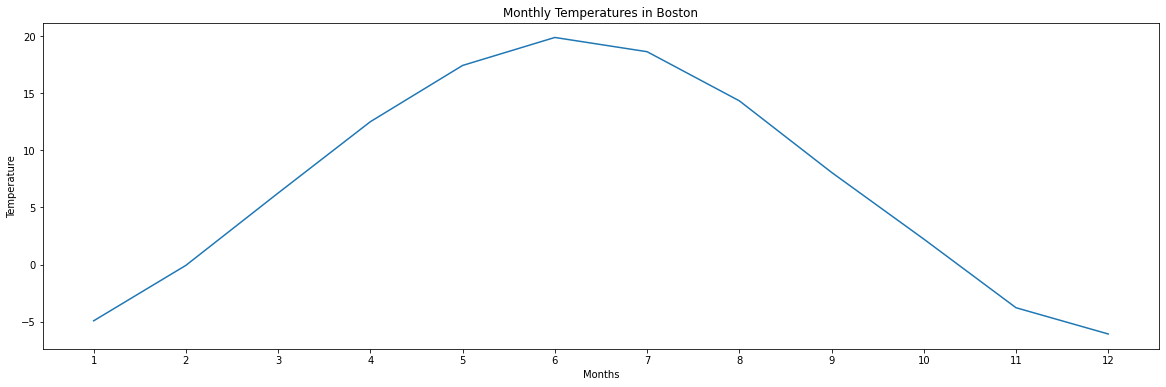

In [622]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Temperatures in Boston')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

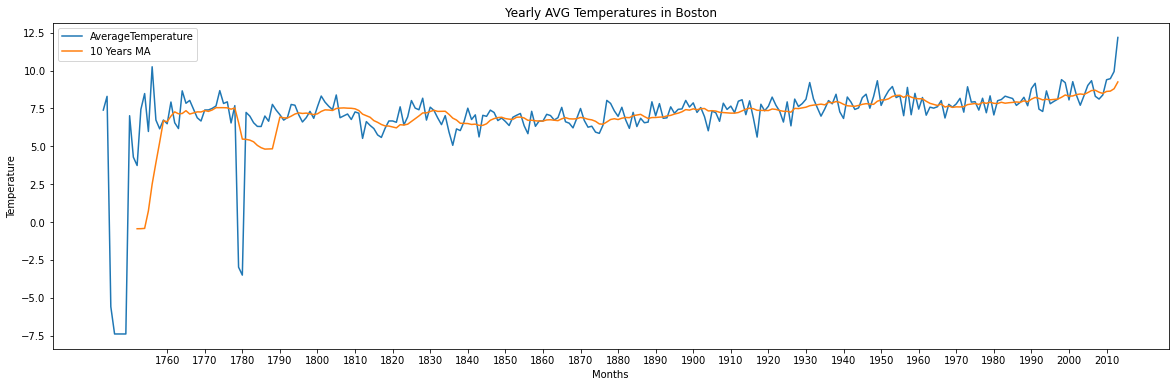

In [623]:
year_avg = pd.pivot_table(
    bostonM,
    values='AverageTemperature',
    index='year',
    aggfunc='mean'
)

year_avg['10 Years MA'] = year_avg['AverageTemperature'].rolling(10).mean()

year_avg[['AverageTemperature','10 Years MA']].plot(figsize=(20,6))

plt.title('Yearly AVG Temperatures in Boston')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([i for i in range(1760, 2020, 10)])
plt.show()

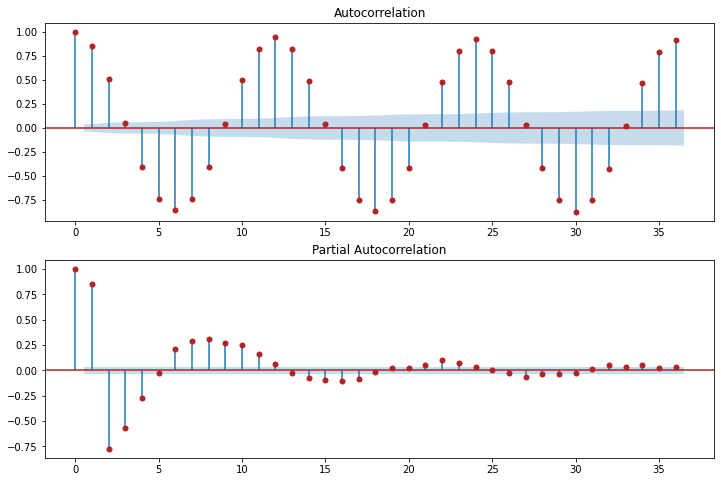

In [624]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(
    boston.AverageTemperature,
    ax=ax1,
    color='firebrick'
)

ax2 = fig.add_subplot(212)
# default lag is being used
fig = sm.graphics.tsa.plot_pacf(
    boston.AverageTemperature,
    ax=ax2,
    color='firebrick'
)

In [625]:
res = adfuller(boston.AverageTemperature[0:120])
print('ADF Statistic on the first decade: {}'.format(res[0]))
print('p-value: {}'.format(res[1]))
print('Critical Values:')
for key, value in res[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the first decade: -2.1382069387664973
p-value: 0.22943140507246612
Critical Values:
	1%: -3.489589552580676
	5%: -2.887477210140433
	10%: -2.580604145195395


The p-value not less than 0.05 thus we can conclude that this dataset is not stationary

# Prediction part

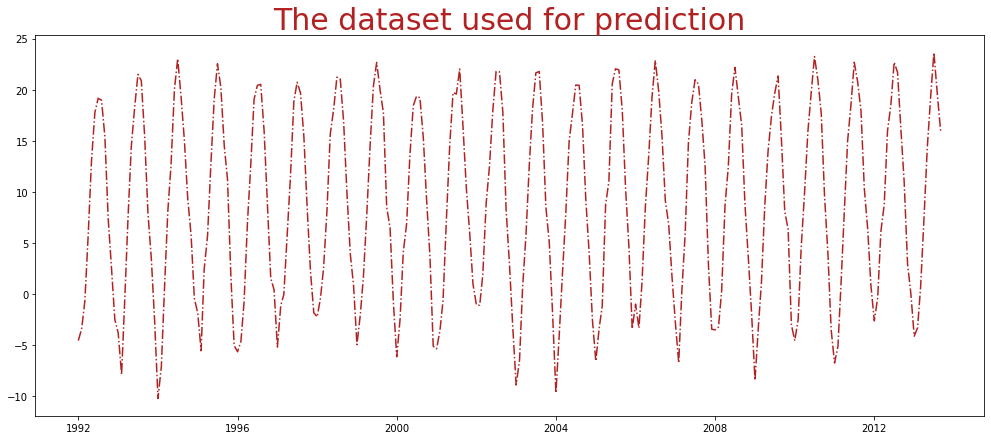

In [626]:
plt.figure(figsize=(17, 7))
plt.title('The dataset used for prediction', fontsize=30,color='firebrick')
pred_data = boston.loc[(boston.index.year >= 1992) & (boston.index.year <= 2013)]
plt.plot(pred_data['AverageTemperature'], '-.', color='firebrick')
plt.show()

In [627]:
X_train, X_test = train_test_split(pred_data, test_size=0.05, shuffle=False)

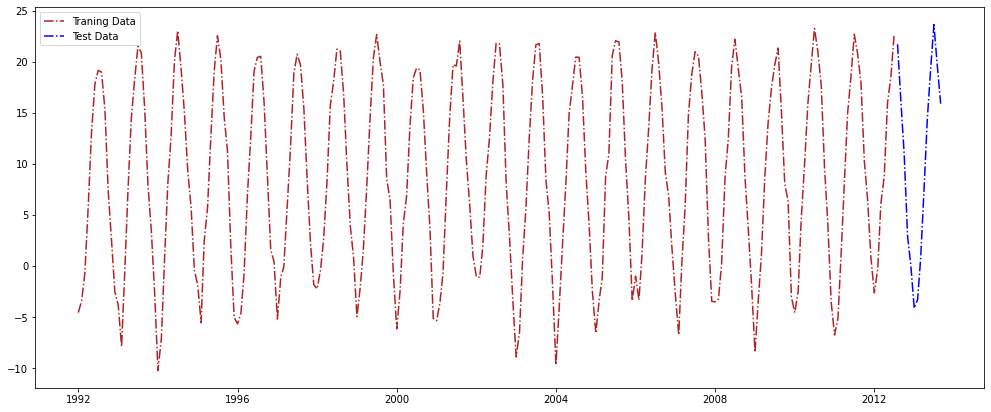

In [628]:
plt.figure(figsize=(17, 7))
plt.plot(
    X_train.index,
    X_train['AverageTemperature'],
    '-.',
    color='firebrick',
    label='Traning Data'
)

plt.plot(
    X_test.index,
    X_test['AverageTemperature'],
    '-.',
    color='blue',
    label='Test Data'
)
plt.legend()
plt.show()

In [629]:
def optimize_SARIMA(orders, series):
    res = list()
    for order in orders:
        model = SARIMAX(series, order=order).fit(disp=-1)
        res.append([order, model.aic])
    resdf = pd.DataFrame(res)
    resdf.columns = ['(p, d, q)', 'AIC']
    resdf = resdf.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return resdf

In [630]:
X_train.index = pd.DatetimeIndex(
    X_train.index.values,
    freq=X_train.index.inferred_freq
)

p = range(1, 3)
d = 1
q = range(1, 10)

parameters = product(p, q)

orders = list()

for each in parameters:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    orders.append(each)
    
result_d1 = optimize_SARIMA(orders, X_train['AverageTemperature'])

result_d1.head()

,"(p, d, q)",AIC
0,"(2, 1, 8)",967.858362
1,"(2, 1, 5)",969.582863
2,"(2, 1, 4)",972.914698
3,"(2, 1, 6)",975.281913
4,"(2, 1, 3)",980.385970


In [631]:
best_models = result_d1.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()
best_models[best_models.columns[0]][0]

best_pdq = best_models[best_models.columns[0]][0]
print("Best  (p, d, q): {}, with AIC: {}".format(best_pdq, best_models.iloc[0].AIC))

Best  (p, d, q): (2, 1, 8), with AIC: 967.8583619762674


In [632]:
model = SARIMAX(
    X_train['AverageTemperature'],
    order=best_pdq
).fit()

In [633]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                  247
Model:               SARIMAX(2, 1, 8)   Log Likelihood                -472.929
Date:                Sat, 26 Jun 2021   AIC                            967.858
Time:                        23:41:20   BIC                           1006.417
Sample:                    01-01-1992   HQIC                           983.384
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7320      0.000   7266.059      0.000       1.731       1.732
ar.L2         -1.0000   6.81e-05  -1.47e+04      0.000      -1.000      -1.000
ma.L1         -2.4676     43.747     -0.056      0.955     -88.209      83.274
ma.L2          2.1398     64.198      0.033      0.973    -123.686     127.965
ma.L3         -0.5505     29.385     -0.019      0.985     -58.144      57.043
ma.L4         -0.0150      5.342     -0.003      0.998     -10.486      10.455
ma.L5         -0.2062      4.698     -0.044      0.965      -9.414       9.001
ma.L6          0.1577      4.394      0.036      0.971      -8.454       8.769
ma.L7         -0.0067      2.558     -0.003      0.998      -5.021       5.008
ma.L8         -0.0515      2.265     -0.023      0.982      -4.491       4.388
sigma2         2.4665    107.898      0.023      0.982    -209.009     213.942
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                11.57
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.37
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

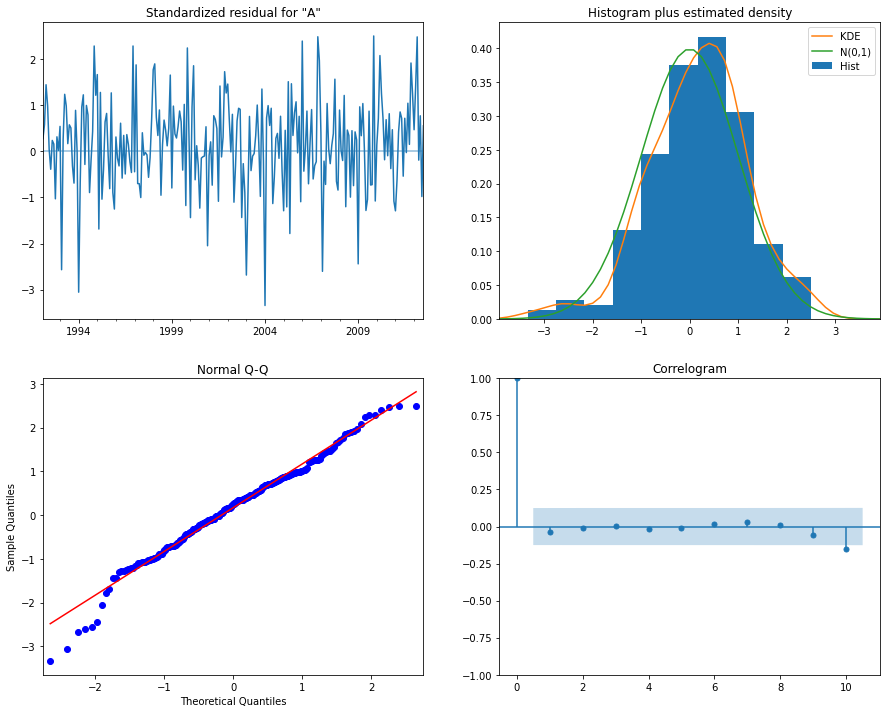

In [634]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [635]:
fore_length = X_test.shape[0] - 1
forecast = model.get_prediction(
    start=X_train.shape[0],
    end=X_train.shape[0] + fore_length
)
forecast_mean = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

In [636]:
forecast_results = forecast.tvalues

In [637]:
test_index = X_test.index.to_list()
test_set = X_test['AverageTemperature']
err = boston.loc[test_index]['AverageTemperatureUncertainty']

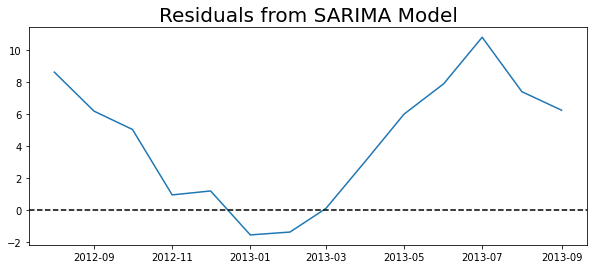

In [638]:
residuals = X_test['AverageTemperature'] - forecast_results.values
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.show()

In [639]:
test_lower = test_set - err
test_upper = test_set + err

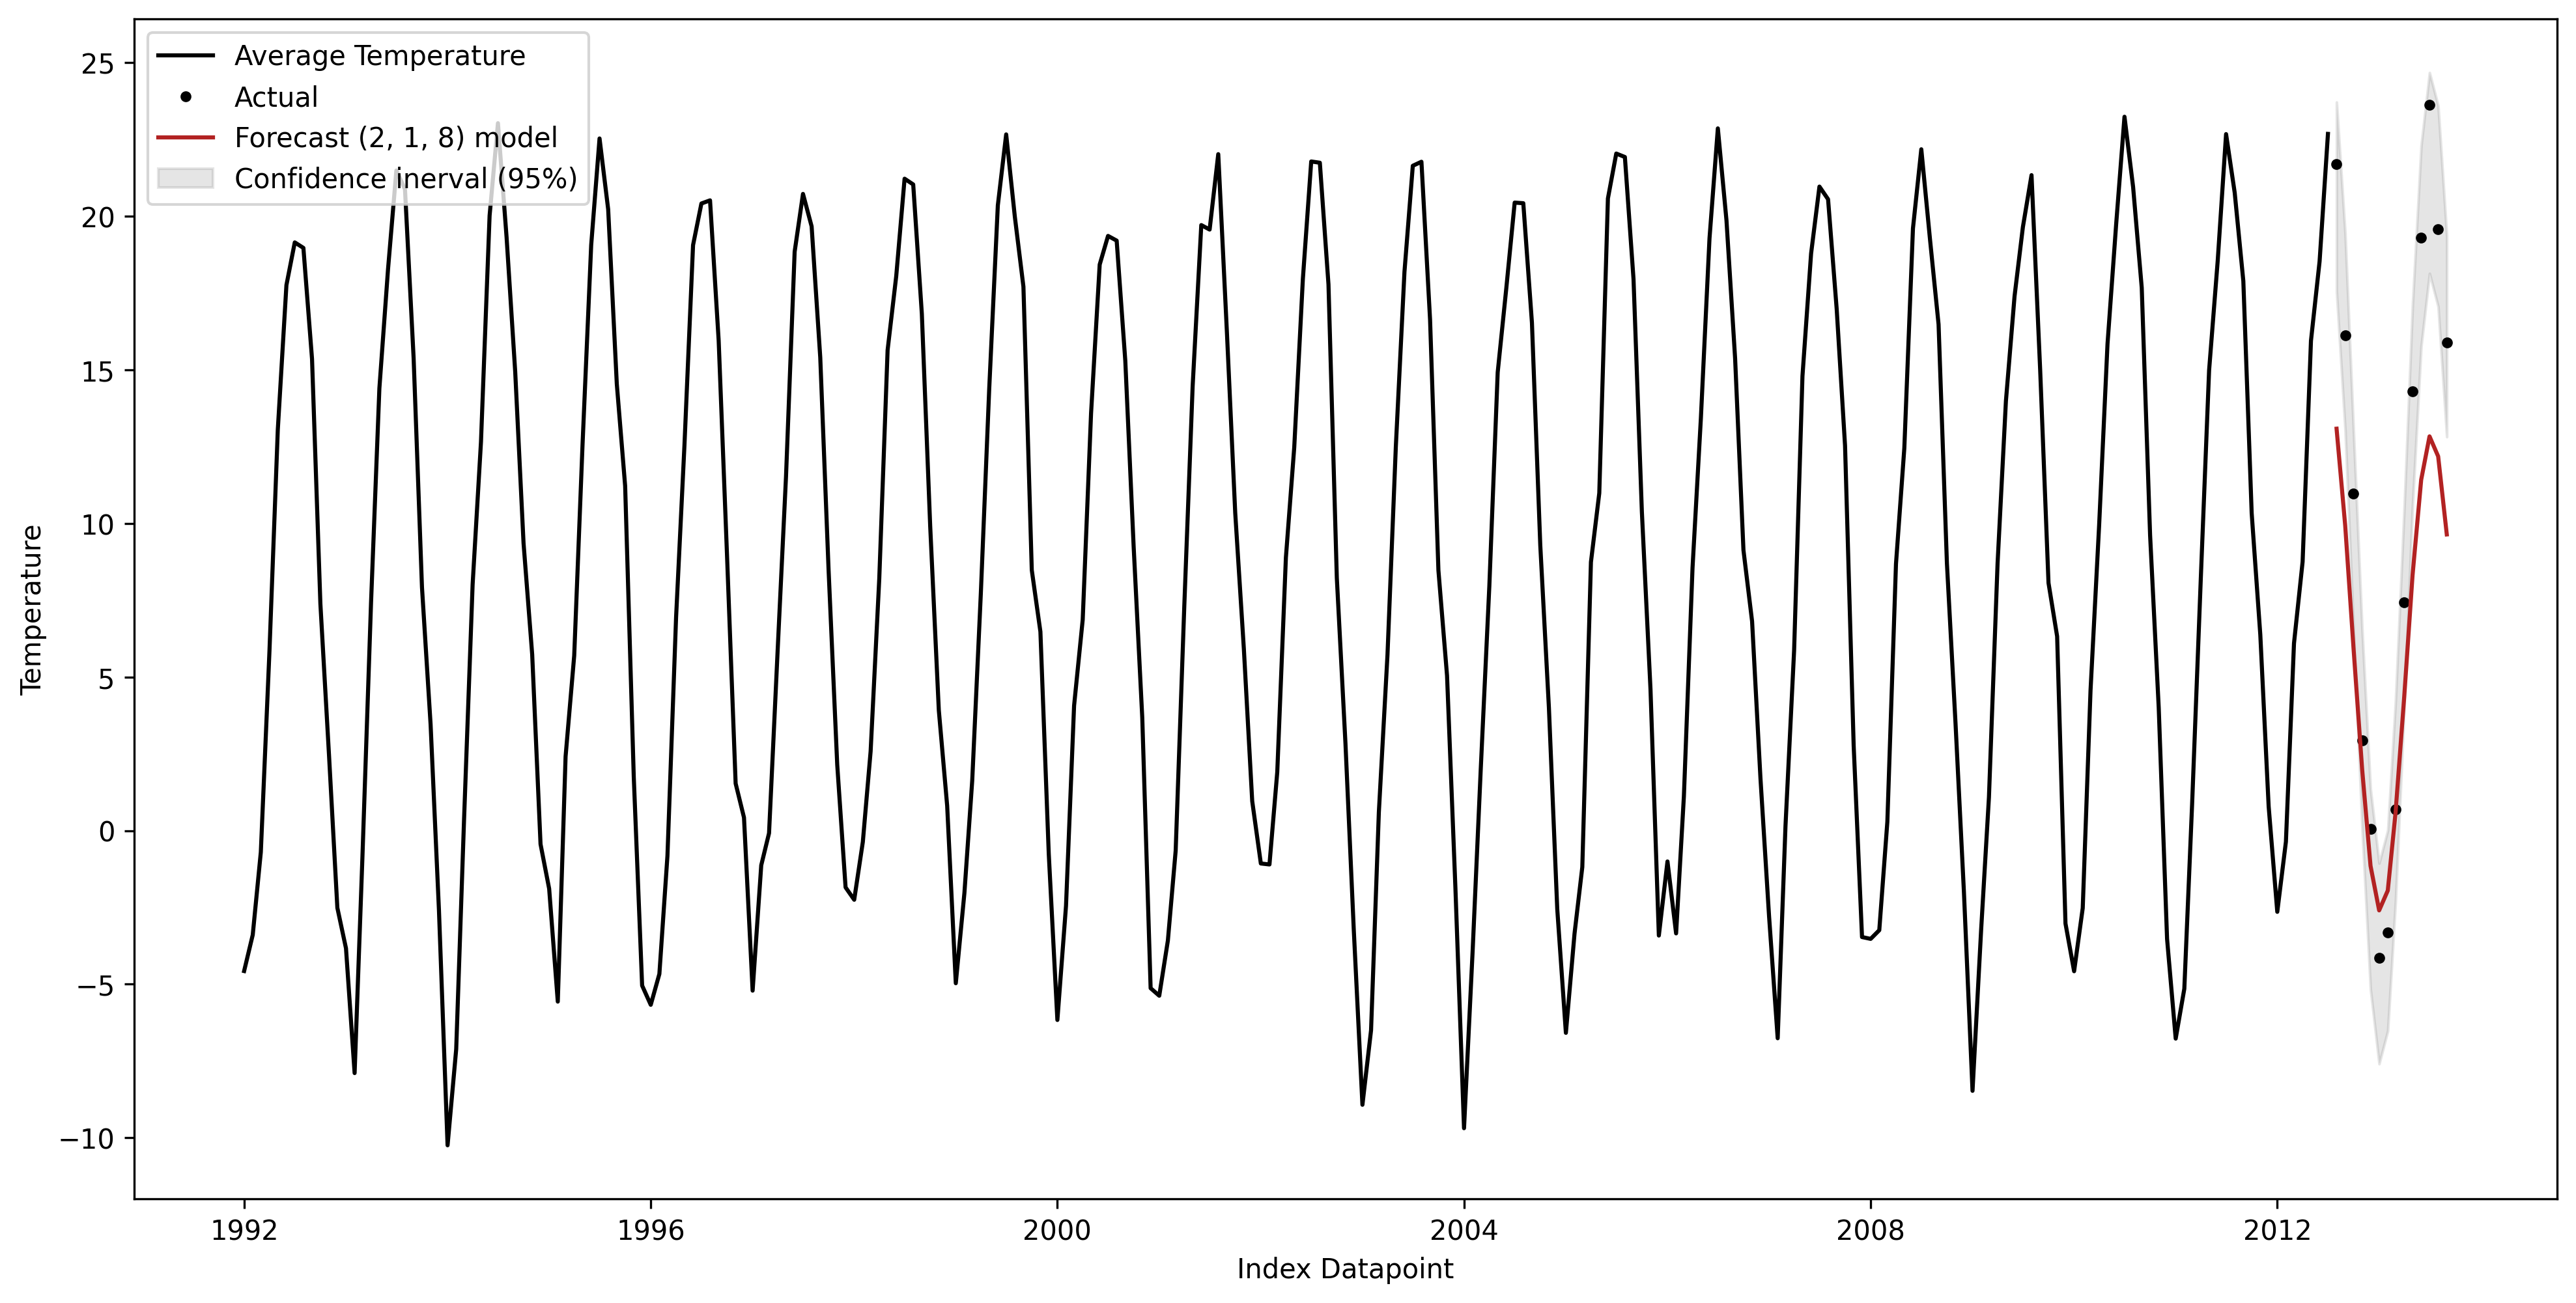

In [640]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)


plt.plot(
    X_train.index,
    X_train['AverageTemperature'],
    'k',
    label = 'Average Temperature'
)

plt.plot(
    X_test.index,
    X_test['AverageTemperature'],
    '.k',
    label = 'Actual'
)

plt.plot(
    forecast_results.index,
    forecast_results.values,
    color='firebrick',
    label='Forecast {} model'.format(best_pdq)
)

ax.fill_between(
    X_test.index,
    ci['lower AverageTemperature'],
    ci['upper AverageTemperature'],
    alpha=0.2,
    label='Confidence inerval (95%)',
    color='grey'
)


plt.legend(loc = 'upper left')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

Text(0, 0.5, 'Temperature')

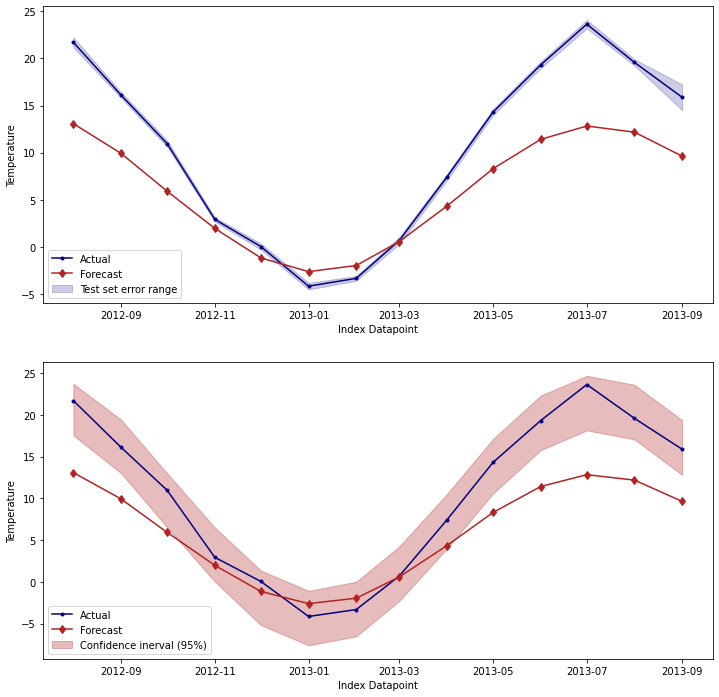

In [641]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)

plt.fill_between(
    test_lower.index,
    test_lower,
    test_upper,
    alpha=0.2,
    label = 'Test set error range',
    color='navy'
)

plt.plot(
    X_test.index,
    X_test['AverageTemperature'],
    marker='.',
    label="Actual",
    color='navy'
)
plt.plot(
    forecast_results.index,
    forecast_results.values,
    marker='d',
    label="Forecast",
    color='firebrick'
)

plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')

plt.legend()
plt.subplot(2,1,2)

plt.plot(
    test_set.index,
    test_set.values,
    marker='.',
    label="Actual",
    color='navy'
)
plt.plot(
    forecast_results.index,
    forecast_results.values,
    marker='d',
    label="Forecast",
    color='firebrick'
)
plt.fill_between(
    ci.index,
    ci['lower AverageTemperature'],
    ci['upper AverageTemperature'],
    alpha=0.3,
    label='Confidence inerval (95%)',
    color='firebrick'
)

plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')

# Using the Rolling Forecast Origin

In [642]:
from datetime import timedelta

roll_pred_date = list()
roll_pred_value = list()
roll_pred['dt'] = X_test.index

for train_end in X_test.index:
    train_data = pred_data[:train_end - timedelta(days=30)]
    
    model = SARIMAX(train_data['AverageTemperature'], order=best_pdq)
    model_fit = model.fit()
    
    pred = model_fit.forecast()
#     print(train_data.shape, pred)
    roll_pred_date.append(train_end)
    roll_pred_value.append(pred.values[0])

In [643]:
rolling_residuals = X_test['AverageTemperature'] - roll_pred_value

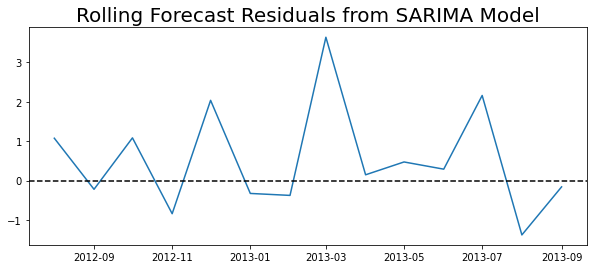

In [644]:
plt.figure(figsize=(10, 4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.show()

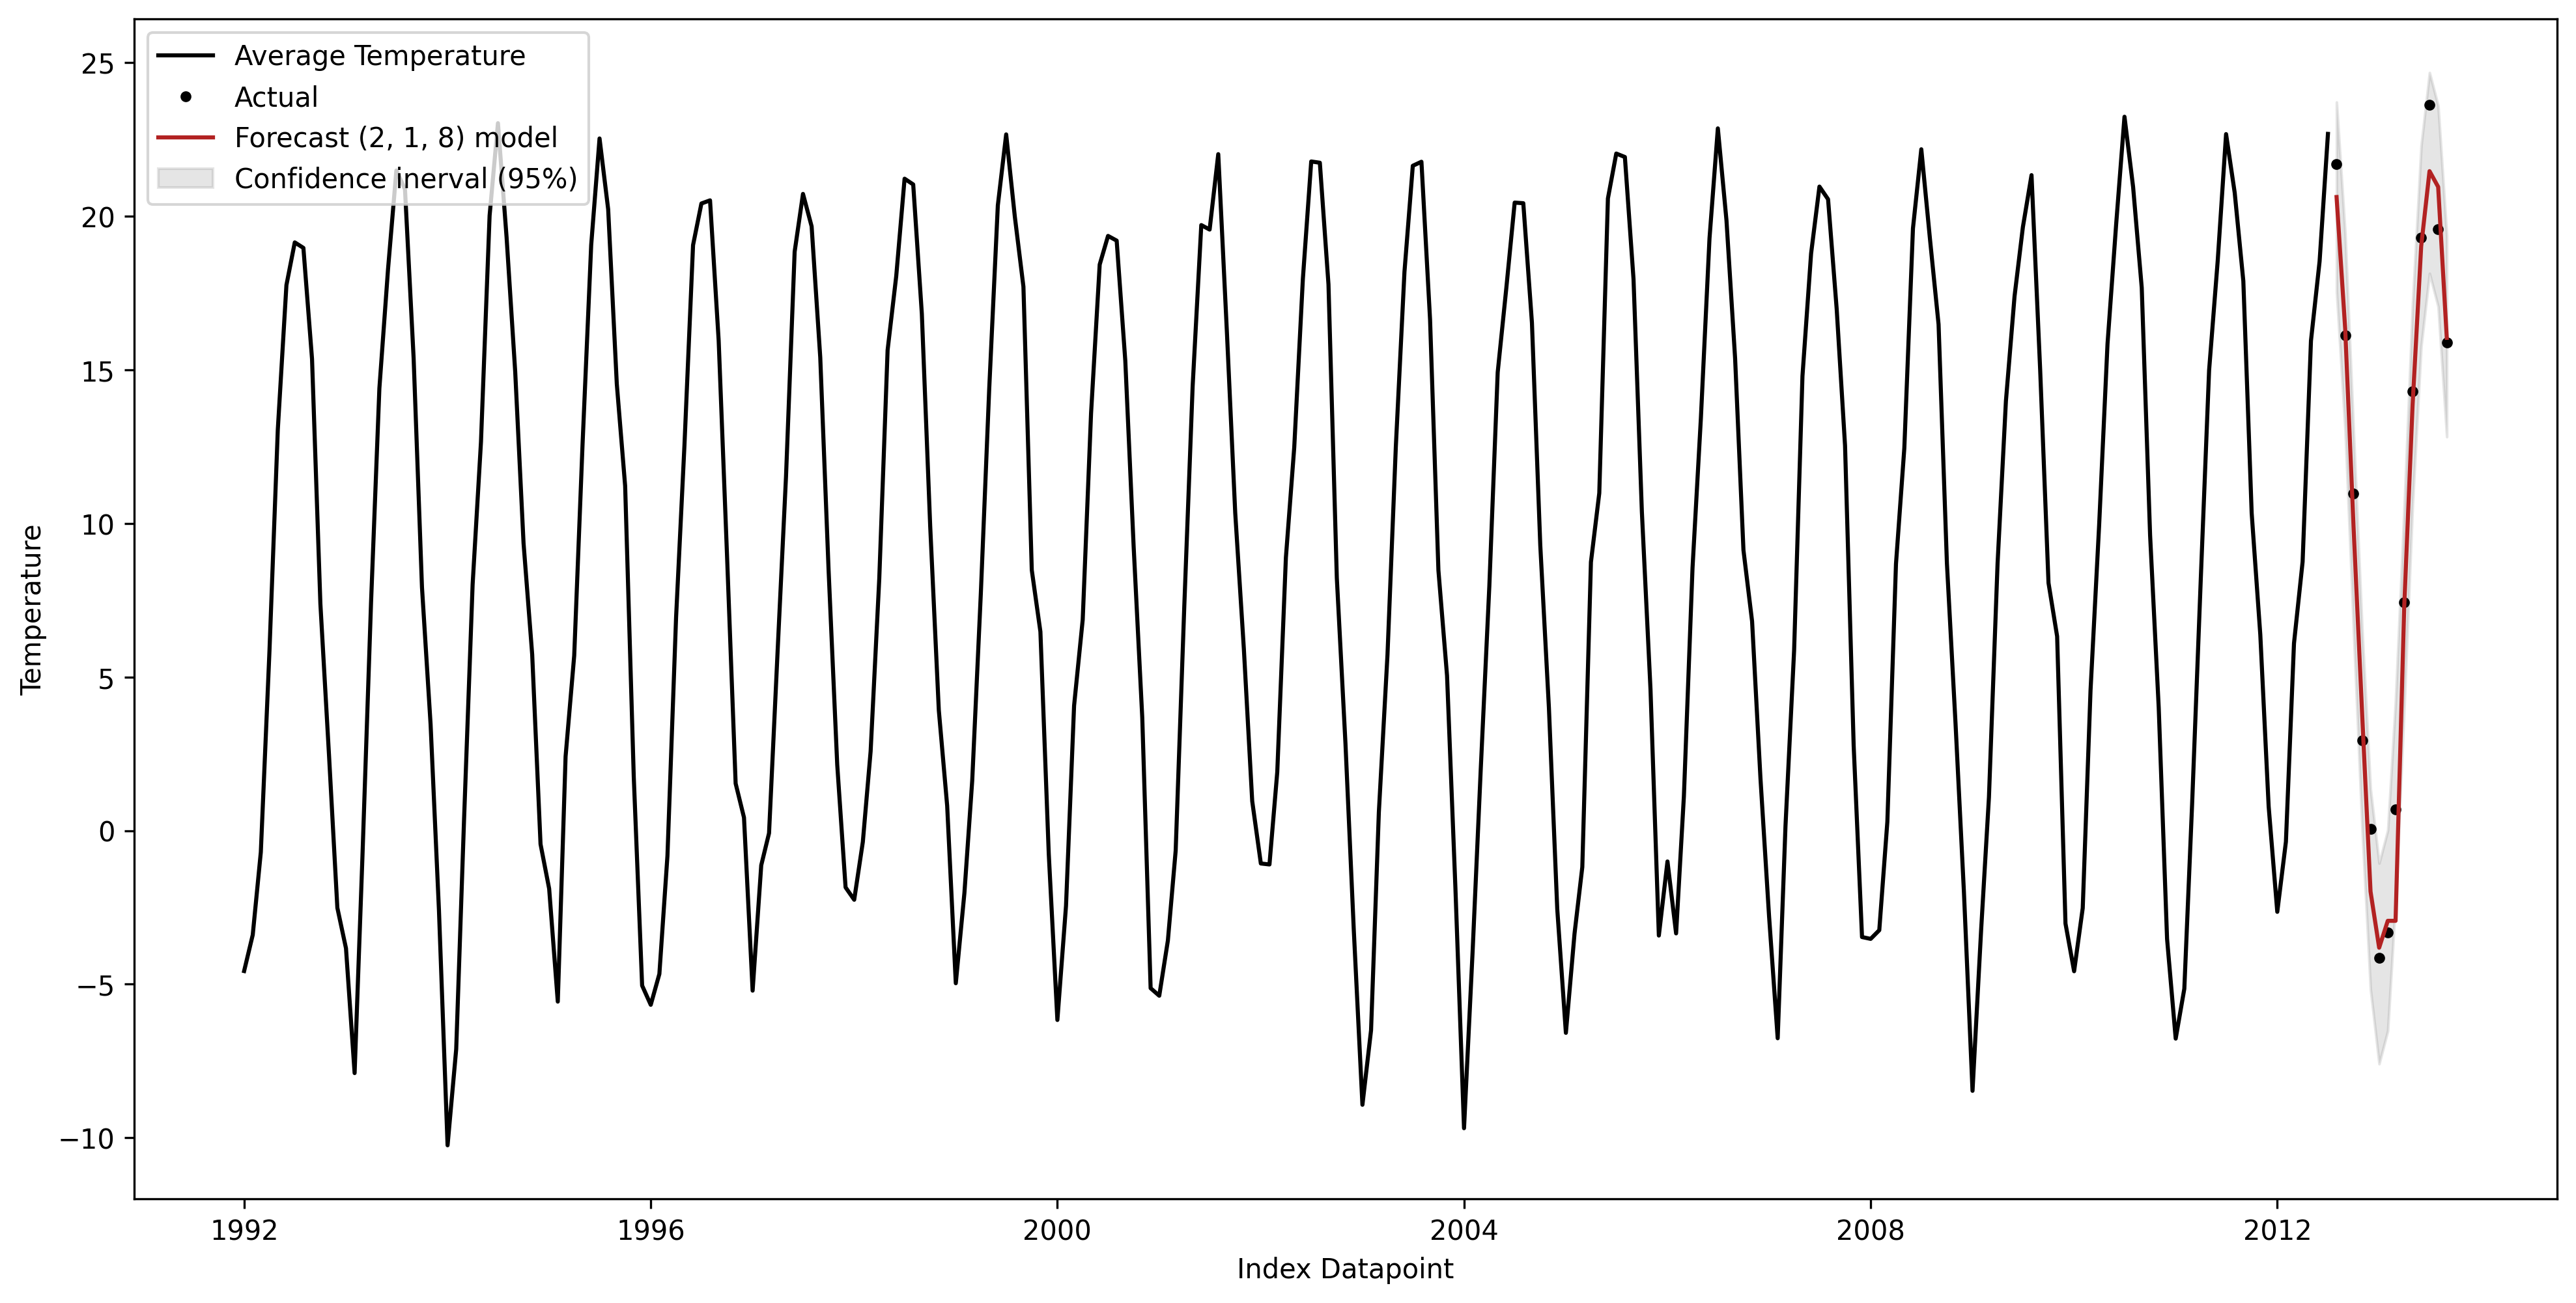

In [647]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)


plt.plot(
    X_train.index,
    X_train['AverageTemperature'],
    'k',
    label = 'Average Temperature'
)

plt.plot(
    X_test.index,
    X_test['AverageTemperature'],
    '.k',
    label = 'Actual'
)

plt.plot(
    roll_pred_date,
    roll_pred_value,
    color='firebrick',
    label='Forecast {} model'.format(best_pdq)
)

ax.fill_between(
    X_test.index,
    ci['lower AverageTemperature'],
    ci['upper AverageTemperature'],
    alpha=0.2,
    label='Confidence inerval (95%)',
    color='grey'
)


plt.legend(loc = 'upper left')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

Text(0, 0.5, 'Temperature')

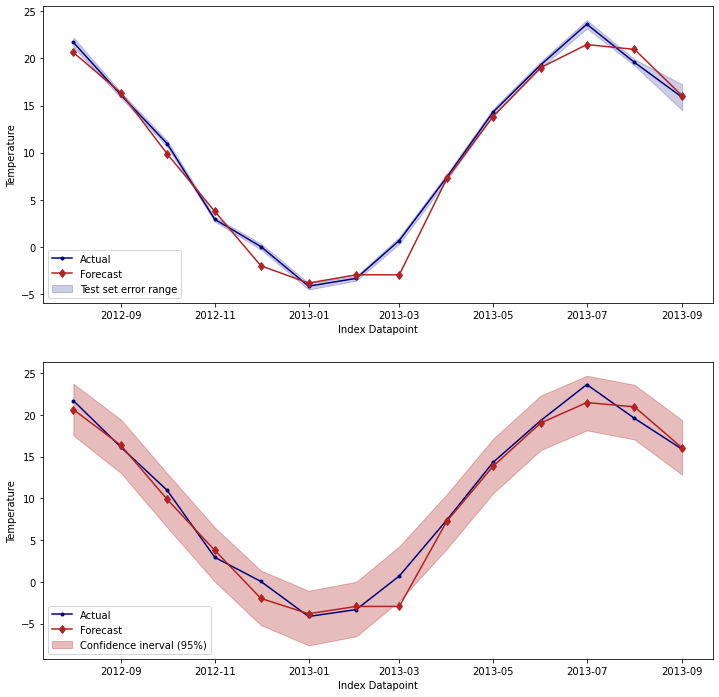

In [648]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)

plt.fill_between(
    test_lower.index,
    test_lower,
    test_upper,
    alpha=0.2,
    label = 'Test set error range',
    color='navy'
)

plt.plot(
    X_test.index,
    X_test['AverageTemperature'],
    marker='.',
    label="Actual",
    color='navy'
)
plt.plot(
    roll_pred_date,
    roll_pred_value,
    marker='d',
    label="Forecast",
    color='firebrick'
)

plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')

plt.legend()
plt.subplot(2,1,2)

plt.plot(
    test_set.index,
    test_set.values,
    marker='.',
    label="Actual",
    color='navy'
)
plt.plot(
    roll_pred_date,
    roll_pred_value,
    marker='d',
    label="Forecast",
    color='firebrick'
)
plt.fill_between(
    ci.index,
    ci['lower AverageTemperature'],
    ci['upper AverageTemperature'],
    alpha=0.3,
    label='Confidence inerval (95%)',
    color='firebrick'
)

plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')